# Data Analysis for CMOS images

## 1. Create the Parameters

### Importing Necessary Libraries and Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import re
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import log_loss, classification_report , confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
import scipy.stats

In [3]:
''' Make directory function '''
def make_dir(data_dir):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

In [5]:
# We create a new directory to store all parameters (Cambiar de directorio para cada CPU)
path_directory = r'C:\Users\erik_\Documents\erik documents\PUCP\Fisica\Altas_Energias_Seminario\Parameters' 
make_dir(path_directory)

In [6]:
# We define the name of the file in which the data is stored
# main_directory: directory where this notebook is stored
main_directory = r'C:\Users\erik_\Documents\erik documents\PUCP\Fisica\Altas_Energias_Seminario' # Data main directory name
# Prefix of the data we want to analyze (e.g. Y_CDS_z000_f093.npz) 
format_name = 'Y_CDS_z' # format prefix name

# In main_directory are two files: one with the Sr data and other with the BG data: 

# We use two data sets, one of the background data and other of Sr source, each has 10 values of z and 500 frames for each z.
dirname_fondo = 'data_fondo_CDS_1000' # Data directory name Background
dirname_Sr =  'data_beta_CDS_1000' # Data directory name Beta particles

# We create a list of the root and file names of all the data to read: 
# In each sublist of the list the first element is the root name: data_beta_CDS_1000, data_fondo_CDS_1000
# In the second element of each sublist is the names of the files for each root name:
# [['...//data_beta_CDS_1000' , [file1,file2,...] , ['...//data_fondo_CDS_1000' , [file1,file2,...]]
root_file_names = [[root,filenames] for root,dirs,filenames in os.walk(main_directory) if (dirname_Sr in root) or (dirname_fondo in root)]

### Create empty lists to store parameters

In [7]:

#################        We create empty lists where we will store parameters from the images         ##################

z_index = 10 # index values for z (10 z values)
background_index = 1 # index values for background (1 background)

# Parameter 1:
mean_values = [[] for i in range(z_index+background_index)] # image mean ADC values

# Parameter 2:
sigma_values = [[] for i in range(z_index+background_index)] # image standard deviation ADC values

# Parameter 3:
var_values = [[] for i in range(z_index+background_index)] # image variance ADC values

# Parameter 4:
max_values = [[] for i in range(z_index+background_index)] # image max ADC intensity values


# Parameter 5:

# Parameter 6:
ClustersAreaMeanArray = [[] for i in range(z_index+background_index)] # We will store the clusters size mean of each frame

# Parameter 7:
ClustersAreaMaxArray = [[] for i in range(z_index+background_index)] # We will store the clusters max size of each frame

# Parameter 8:

# Parameter 9:

# Parameter 10:

# Parameter 11:
# We calculate the mean energies in every cluster, then we take max value of all these mean energies in each frame
Max_MeanEnergiesArray = [[] for i in range(z_index+background_index)] 

# Parameter 12:
# We calculate the mean energies in every cluster, then take the mean value of all these mean energies in each frame
Mean_MeanEnergiesArray =  [[] for i in range(z_index+background_index)]

# Parameter 13:
# We calculate the total energies in every cluster, then we take the max value of these total energies in each frame
Max_TotalEnergiesArray =  [[] for i in range(z_index+background_index)]

# Parameter 14:
# We calculate the total energies in every cluster, then we take the mean value of these total energies in each frame
Mean_TotalEnergiesArray = [[] for i in range(z_index+background_index)]

# Parameter 15: 
# We calculate the max energies (max ADC or Seed) in every cluster, then we take the mean value of these max energies in each frame
Mean_MaxEnergiesArray = [[] for i in range(z_index+background_index)]

In [8]:
# Function to calculate the pedestal value, mean of frame plus sigma of frame times a integer
def threshold_val(MeanFrame,SigmaFrame,SigmaMult):
    ''' An iluminated cluster must have an intensity of 'SigmaMult' sigmas over the mean value of the frame '''
    return  MeanFrame + SigmaMult*SigmaFrame

### Iterate over each root and file, create parameters and store them

In [20]:
# We iterate over the root files and files in the directory of exposed data and background data of 1944x2592 images

# Threshold Value in frame:
NumberOfSigmas = 5 # Number of sigmas to consider

# Start Time
start_time = time.time()

# Extract the root and the file names
for idx,[root,file_names] in enumerate(root_file_names):
    # Iterate over the filenames for one of the 2 roots (BG and Sr)
    for filename in file_names:

        # Consider only the filenames that has 'Y_CDS_z' as part of the string and only for the Sr files
        if format_name in filename:
            # We extract the z index, can be 0,...,9
            char = re.search('CDS_z00(.+?)_f', filename) # Extract the z value of the file
            char = char.group(1)
            
            # Extract the data (images)
            extract_data = np.load(os.path.join(root,filename)) # Load frame
            img = abs(np.array(extract_data.f.arr_0)) 
            
            MeanFrame = img.mean() # Mean of frame
            StdFrame = img.std() # Std of fram

            # Store the parameters in separated lists
            
            ########    Parameter 1    #######
            max_values[int(char) + idx*z_index].append(img.max()) # Frames max values
            ########    Parameter 2    #######
            sigma_values[int(char) + idx*z_index].append(StdFrame) # Frames std values
            ########    Parameter 3    #######
            var_values[int(char) + idx*z_index].append(img.var()) # Frames variance values
            ########    Parameter 4    #######
            mean_values[int(char) + idx*z_index].append(MeanFrame) # Frames mean values
            
            # Threshold Value in frame:
            threshold_value = threshold_val(MeanFrame,StdFrame,NumberOfSigmas)
            
            # Matrix of True and False, True if the ADC is bigger than threshold val, False otherwise:
            True_Value_Matrix = img > threshold_value 

            # We substract the threshold value to the image so we get only the clusters to identify and the real 
            # energy deposited in the cells
            img_filtered = np.trunc(img*True_Value_Matrix - threshold_value*True_Value_Matrix)
            img_filetred8b = np.uint8(img_filtered)
            
            # To identify the cluster we apply a binary threshold filter, 255 for the clusters are and 0 elsewhere
            ret, thresh = cv2.threshold(img_filetred8b,0,255,cv2.THRESH_BINARY) # Thresh is the binary matrix
            
            # Cluster identification: NumClusters = Number of clusters, stats(ycoord,xcoord,height,width,cluster area) 
            #                         of each cluster in frame
            NumClusters, labels , stats, centroids = cv2.connectedComponentsWithStats(thresh)
            
            #######    Parameter 5    #######   
            # The area of all clusters size(area) in a given frame (Multiplicity)
            ClustersArea = stats.T[cv2.CC_STAT_AREA][1:]
            
            #######    Parameter 6    #######  
            # Cluster sizes mean: Mean size of all clusters in a given image
            ClustersAreaMean = ClustersArea.mean() # Take mean
            ClustersAreaMeanArray[int(char) + idx*z_index].append(ClustersAreaMean) # Store in array
            
            #######    Parameter 7    ####### 
            # Cluster sizes max: Max size of all clusters in a given image
            ClustersAreaMax = ClustersArea.max() # take max
            ClustersAreaMaxArray[int(char) + idx*z_index].append(ClustersAreaMax) # Store in array
            
            # Coordinates of all clusters
            x_coords = stats.T[cv2.CC_STAT_LEFT][1:] #  Left coordinate of square cluster grid
            y_coords = stats.T[cv2.CC_STAT_TOP][1:] # Top coordinate of square cluster grid
            width = stats.T[cv2.CC_STAT_WIDTH][1:] # width values of each cluster
            height = stats.T[cv2.CC_STAT_HEIGHT][1:] # height values of each cluster
            
            # We create 3 fixed size arrays where we will store the mean energies, total energy and max energy (seed) from each
            # cluster:
            
            #######    Parameter 8    #######
            MeanEnergies = np.ones(NumClusters-1 ,dtype = np.float64) # mean energies of the clusters
            
            #######    Parameter 9    #######
            TotalEnergies = np.ones(NumClusters-1, dtype = np.float64) # Total energies of the clusters
            
            #######    Parameter 10    #######
            MaxEnergies = np.ones(NumClusters-1 , dtype = np.float64) # Max energies of the clusters (seed)
            
            # We iterate over all clusters detected in the frame
            for i in range(NumClusters - 1):
                
                # We extract the subframe (cluster coordinates) from the filtered image, the image substracted by the threshold value
                cluster =  img_filetred8b[y_coords[i] : y_coords[i] + height[i] , x_coords[i] : x_coords[i] + width[i]] 
                
                TotalE = cluster.sum() # Total energy from a given cluster in ADC units
                Seed = cluster.max() # Max energy in a given cluster in ADC units
                MeanE = TotalE/ClustersArea[i] # Mean energy from a given cluster in ADC units
                
                # Store in given arrays
                TotalEnergies[i] = TotalE 
                MaxEnergies[i] = Seed
                MeanEnergies[i] = MeanE
                
            # We now take the mean or max form MeanEnergies, TotalEnergies or MaxEnergies:
            
            #######    Parameter 11    #######
            Max_MeanEnergies = MeanEnergies.max() # We take the max of all clusters mean energies 
            Max_MeanEnergiesArray[int(char) + idx*z_index].append(Max_MeanEnergies)
            
            #######    Parameter 12    #######
            Mean_MeanEnergies = MeanEnergies.mean() # We take the mean of all clusters mean energies
            Mean_MeanEnergiesArray[int(char) + idx*z_index].append(Mean_MeanEnergies)
            
            #######    Parameter 13    #######
            Max_TotalEnergies = TotalEnergies.max() # We take the max of all clusters total energies
            Max_TotalEnergiesArray[int(char) + idx*z_index].append(Max_TotalEnergies)
            
            #######    Parameter 14    #######
            Mean_TotalEnergies = TotalEnergies.mean() # We take the mean of all clusters total energies
            Mean_TotalEnergiesArray[int(char) + idx*z_index].append(Mean_TotalEnergies)
            
            #######    Parameter 15    #######
            Mean_MaxEnergies = MaxEnergies.mean() # We take the mean of all clusters max energies
            Mean_MaxEnergiesArray[int(char) + idx*z_index].append(Mean_MaxEnergies)

# Print the execution time
end_time = time.time()
print('Total execution time: ',(end_time-start_time)/60.)

Total execution time:  27.07778089841207


In [21]:
# We save all the arrays in the new directory with different file names:

parameters_names = ['MeanFrame', 'SigmaFrame','VarianceFrame','MaxFrame', 'ClustersAreaMean','ClustersAreaMax',
                    'Max_MeanEnergies','Mean_MeanEnergies','Max_TotalEnergies','Mean_TotalEnergies','Mean_MaxEnergies' ]

parameters_data = [mean_values,sigma_values,var_values,max_values,ClustersAreaMeanArray,ClustersAreaMaxArray,
                  Max_MeanEnergiesArray,Mean_MeanEnergiesArray,Max_TotalEnergiesArray,Mean_TotalEnergiesArray,
                  Mean_MaxEnergiesArray]

for idx,param in enumerate(parameters_names):
    np.save(os.path.join(path_directory,param+'.npy'),parameters_data[idx])

# # Parameter 1: Mean of frame
# # Parameter 2: Sigma of frame
# # Parameter 3: Variance of frame
# # Parameter 4: Max of frame
# # Parameter 6: Mean size of all clusters in a frame
# # Parameter 7: Max size of all clusters in a frame
# # Parameter 11: Max value of all mean energies deposited in each cluster in a frame
# # Parameter 12: Mean value of all mean energies deposited in each cluster in a frame
# # Parameter 13: Max value of all total energies deposited in each cluster in a frame
# # Parameter 14: Mean value of all total energies deposited in each cluster in a frame
# # Parameter 15: Mean value of all max energies deposited in each cluster in a frame


## 2. Read parameters data, plot distributions and relations

### Extract Data Function 

In [9]:
def extract_data(parameters_directory):
    ''' Input: Directory where the .npy data parameters are stored '''
    # parameters_directory = 'Parameters'
    data_dict = {}
    for filename in os.listdir(parameters_directory):
        name = re.search('(.+?).npy', filename) # Extract the name of the parameter
        name = name.group(1)
        data = np.load(os.path.join(parameters_directory,filename))
        data_dict[name] = data #Store the parameter data in a dictionary where the key is the parameter name and the value is the data list
    return data_dict

### Plot Distance vs Parameter Function

In [10]:
def plot_zeta_vs_parameter(zeta_vals ,parameter_name,parameters_dist):
    ''' Plot distance (Z) vs parameters 
    Inputs:
    - zeta_vals: 11 size array of string of distances: ['z0','z1',..,'z9','bg']
    - parameter_name: Name of the parameter to plot (Ex. Maximum)
    - parameters_dist: All z values for the given parameter is an array of shape (11,500) 
                       11 distances and 500 values extracted from each frame. '''
    
    parameter_vals = [np.array(z_distance).mean() for z_distance in parameters_dist] # We take the mean for each z
    parameter_vals_std = [np.array(z_distance).std() for z_distance in parameters_dist] # We take the mean for each z 
    
    zeta_repeat = [ item for item in zetas for repetitions in range(500) ] # Create a list of strings of each z distance repeated 500 times
    parameters_dist_flat = parameters_dist.flatten()
    
    # Agregar:

    plt.figure(figsize=[11,9])
    plt.plot(zeta_vals,parameter_vals,linewidth=2,c='tab:blue',alpha=0.9)
#     plt.scatter(zeta_repeat,parameters_dist_flat,s=0.3)
    plt.errorbar(zeta_vals, parameter_vals , yerr=parameter_vals_std, fmt="o",capsize=4,c='tab:blue',alpha=0.9)
    plt.xlabel('Distance from Source',fontsize=15)
    plt.ylabel(f'{parameter_name} Intensity from ADCs',fontsize=15)
    plt.title(f'{parameter_name} values for each z and BG',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()
    
    


### Plot Distributions Function

In [11]:
def plot_set_of_histograms(list_of_data,number_of_bins,title,x_name,labels):
    ''' Plot the distributions of a parameter values:
    - list_of_data: An array containing in each element all 500 data from each parameter 
                    (Ex.: list_of_data_VarianceFrames = [dataZ0,dataZ1,...,dataBG])
    - number_of_bins: An array where each element is the number of bins to consider for each distribution.
    - title: Title of plot
    - x_name: Parameter Name 
    - labels: list of z distances to consider (Ex. ['Z0','Z1',...,'BG'])'''
    
#     colors = ['k','tab:brown','b','g','r','c','m','y','tab:gray','tab:orange']
    colors2 = ['tab:orange','g','k','tab:brown','b','r','c','m','y','tab:gray',(0.1,0.5,0.9)]
    plt.figure(figsize=[11,9])
    edges_min = []
    edges_max = []
    for idx,element in enumerate(list_of_data):
        hist,bin_edge = np.histogram(element , bins = number_of_bins[idx] , density=True)
        width=np.diff(bin_edge)[0]
        plt.step(bin_edge[1:],hist, linestyle = '-', linewidth = 2 , color = colors2[idx],alpha=0.6)
#         plt.bar(bin_edge[:-1], hist,color=colors2[idx],edgecolor=colors2[idx],width=width , alpha=0.2 , label = labels[idx])
#         kwargs = dict()
        plt.hist(element, histtype='stepfilled', alpha=0.2, density=True, bins=number_of_bins[idx],label=labels[idx],
                 color=colors2[idx])
#         plt.hist(element, histtype='bar', alpha=0.4, density=True, bins=number_of_bins,label=labels[idx],rwidth=0.8)
        edges_min.append(min(bin_edge))
        edges_max.append(max(bin_edge))
    plt.xlim(min(edges_min), max(edges_max))
    plt.xlabel('ADC ' + x_name,fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)
    plt.title(title,fontsize=15)
    plt.show()

In [12]:
# Extract the parameters data in a dictionary
data_dictionary = extract_data('Parameters')

# We create the x array names for plotting data
zetas = ['z00'+str(i) for i in range(10)] # Create a list of strings of each z distance
zetas.append('BG') # Add BG string
zeta_repeat = [ item for item in zetas for repetitions in range(500) ] # Create a list of strings of each z distance repeated 500 times

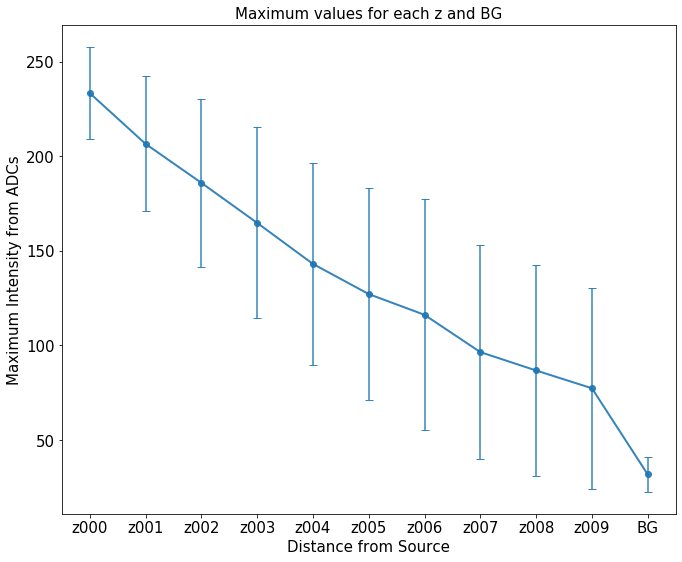

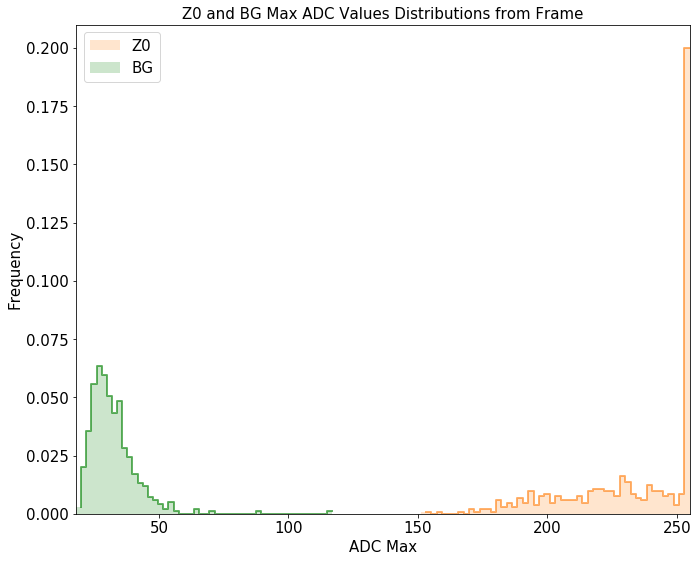

In [13]:
# Plot Maximum array vs zetas
plot_zeta_vs_parameter(zetas,'Maximum',data_dictionary['MaxFrame'])
plot_set_of_histograms([data_dictionary['MaxFrame'][0],data_dictionary['MaxFrame'][-1]],[50,50],
    'Z0 and BG Max ADC Values Distributions from Frame', 'Max',['Z0','BG'])

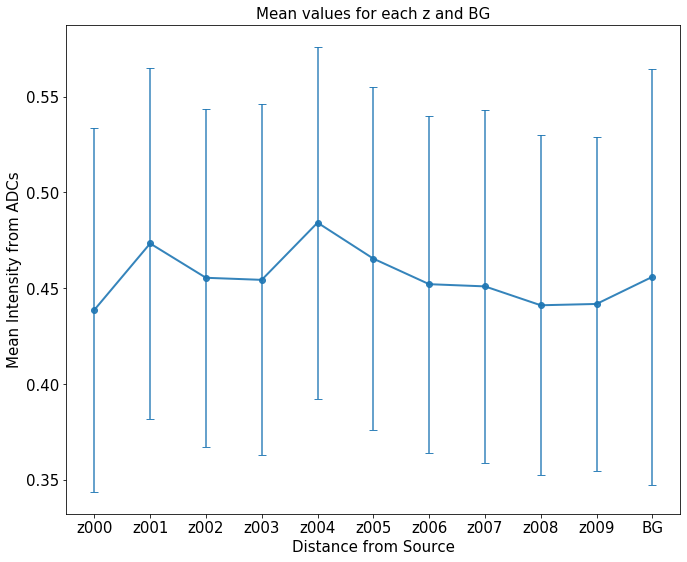

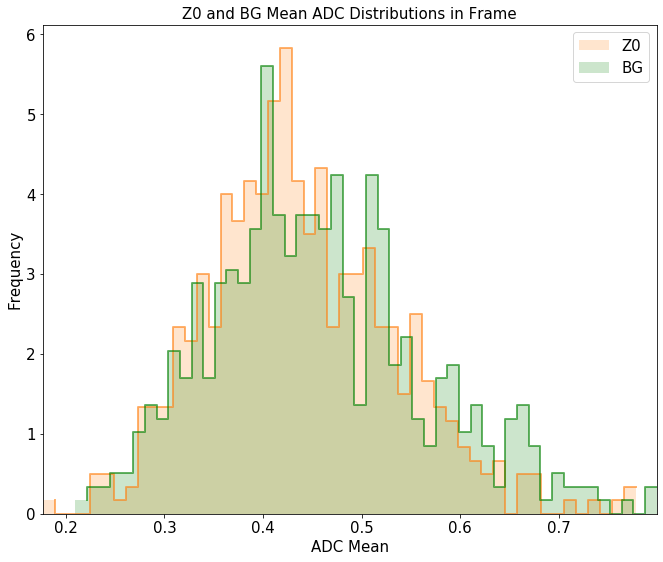

In [14]:
# Array of the mean of max values
plot_zeta_vs_parameter(zetas,'Mean',data_dictionary['MeanFrame'])
plot_set_of_histograms([data_dictionary['MeanFrame'][0],data_dictionary['MeanFrame'][-1]],[50,50],
    'Z0 and BG Mean ADC Distributions in Frame', 'Mean',['Z0','BG'])


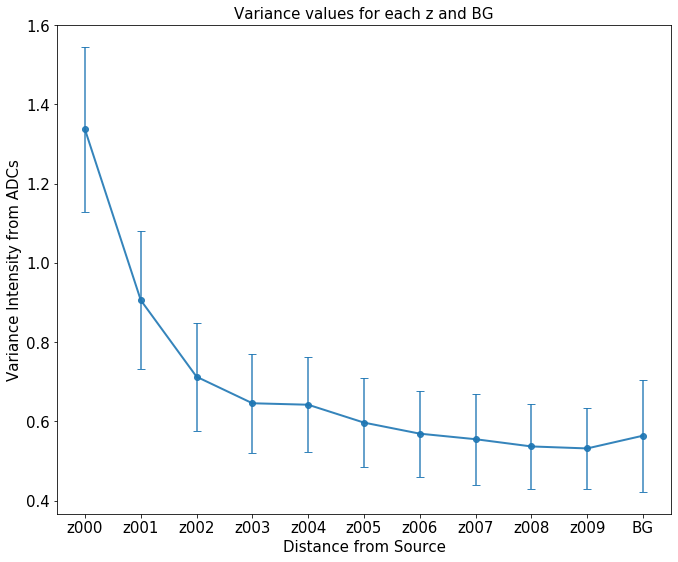

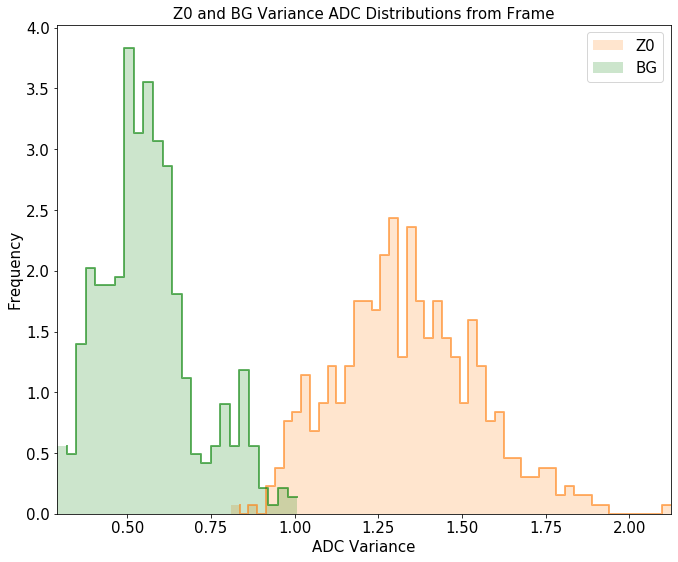

In [15]:
# Mean of variances of all frames in each z
plot_zeta_vs_parameter(zetas,'Variance',data_dictionary['VarianceFrame'])
plot_set_of_histograms([data_dictionary['VarianceFrame'][0],data_dictionary['VarianceFrame'][-1]],[50,25],
    'Z0 and BG Variance ADC Distributions from Frame', 'Variance',['Z0','BG'])

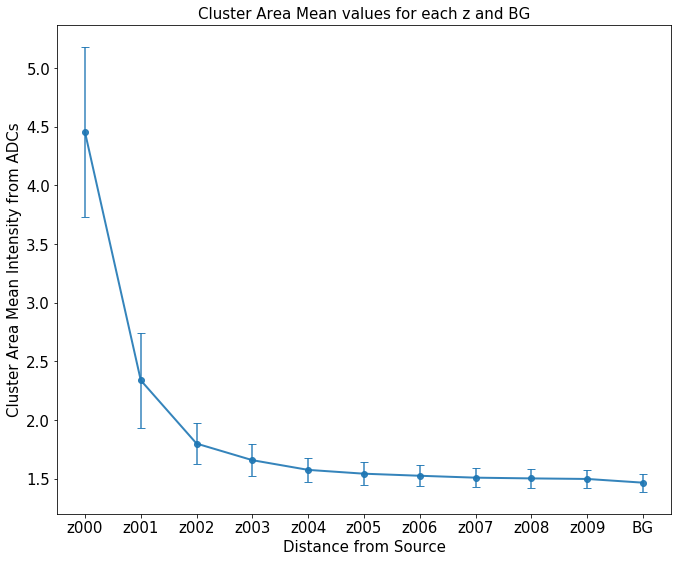

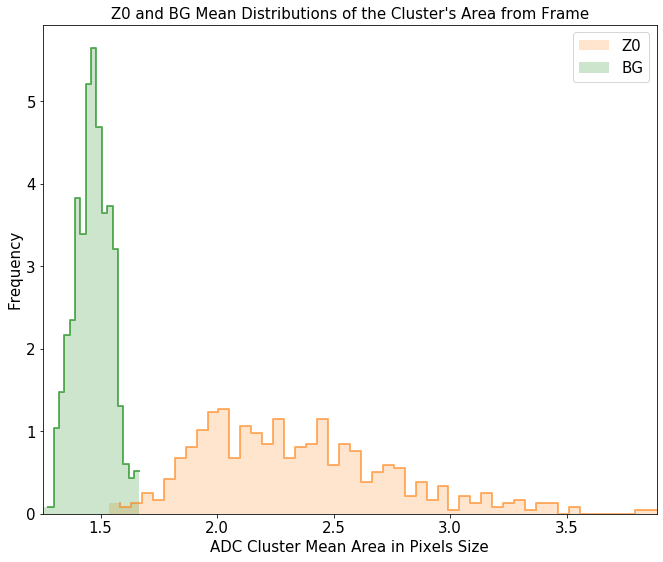

In [16]:
# Clusters area mean array from each img from each z
plot_zeta_vs_parameter(zetas,'Cluster Area Mean',data_dictionary['ClustersAreaMean'])
plot_set_of_histograms([data_dictionary['ClustersAreaMean'][1],data_dictionary['ClustersAreaMean'][-1]],[50,18],
    "Z0 and BG Mean Distributions of the Cluster's Area from Frame", 'Cluster Mean Area in Pixels Size',['Z0','BG'])

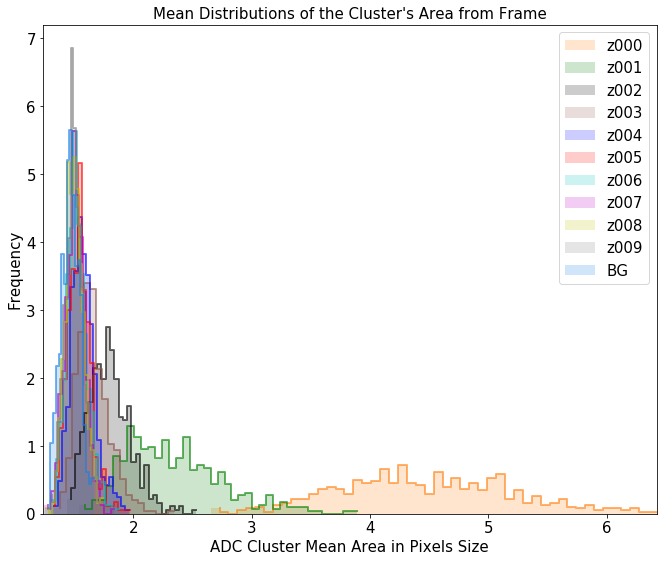

In [17]:
plot_set_of_histograms(data_dictionary['ClustersAreaMean'],[50,40,30,20,20,20,20,20,20,20,18],
    "Mean Distributions of the Cluster's Area from Frame", 'Cluster Mean Area in Pixels Size',zetas)

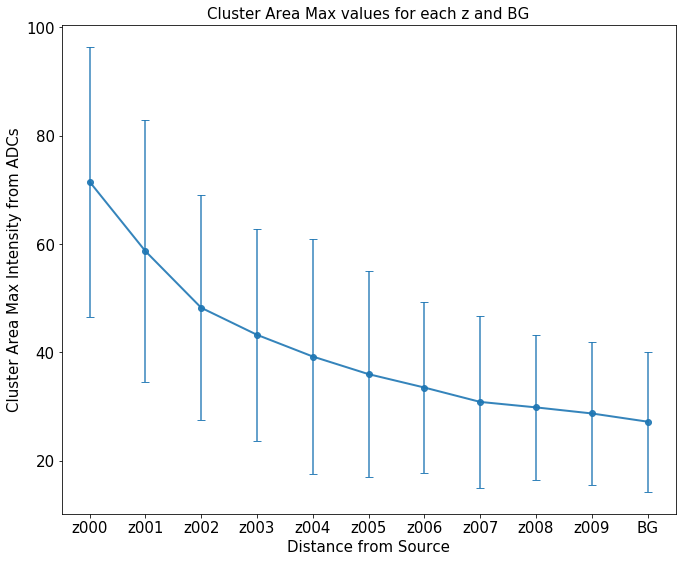

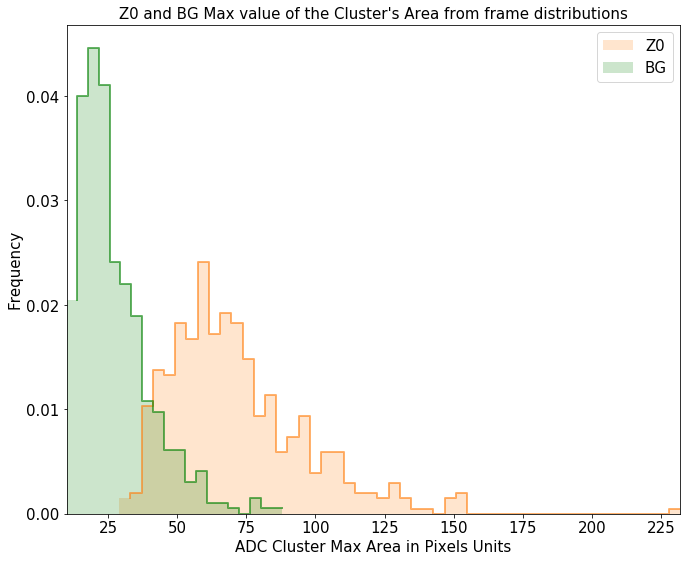

In [18]:
# Cluster area max array from each img from each z
plot_zeta_vs_parameter(zetas,'Cluster Area Max',data_dictionary['ClustersAreaMax'])
plot_set_of_histograms([data_dictionary['ClustersAreaMax'][0],data_dictionary['ClustersAreaMax'][-1]],[50,20],
    "Z0 and BG Max value of the Cluster's Area from frame distributions", 'Cluster Max Area in Pixels Units',['Z0','BG'])


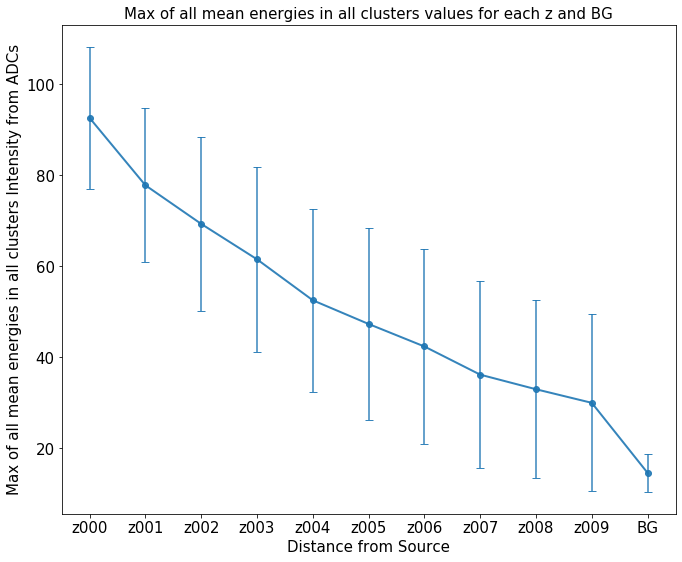

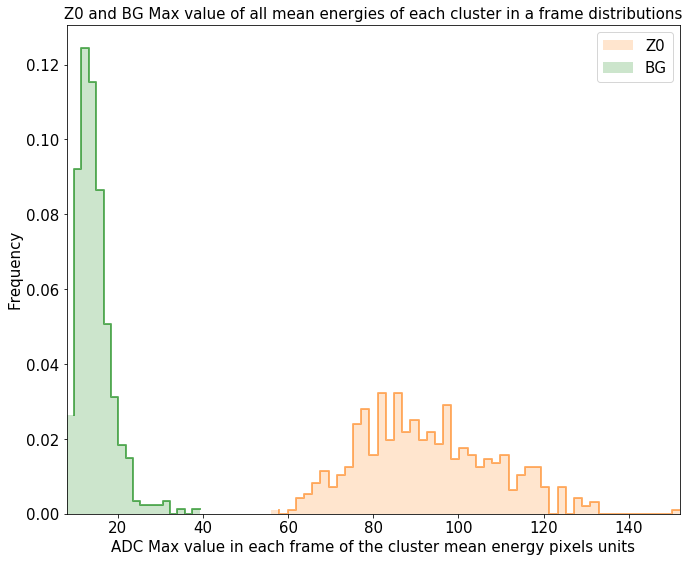

In [19]:
# Max of cluster mean energies in each frame
plot_zeta_vs_parameter(zetas,'Max of all mean energies in all clusters',data_dictionary['Max_MeanEnergies'])
plot_set_of_histograms([data_dictionary['Max_MeanEnergies'][0],data_dictionary['Max_MeanEnergies'][-1]],[50,18],
    "Z0 and BG Max value of all mean energies of each cluster in a frame distributions",
     'Max value in each frame of the cluster mean energy pixels units',['Z0','BG'])

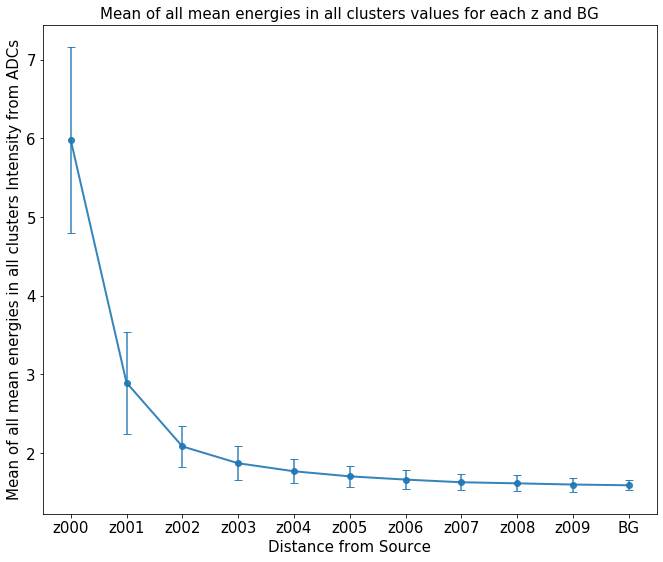

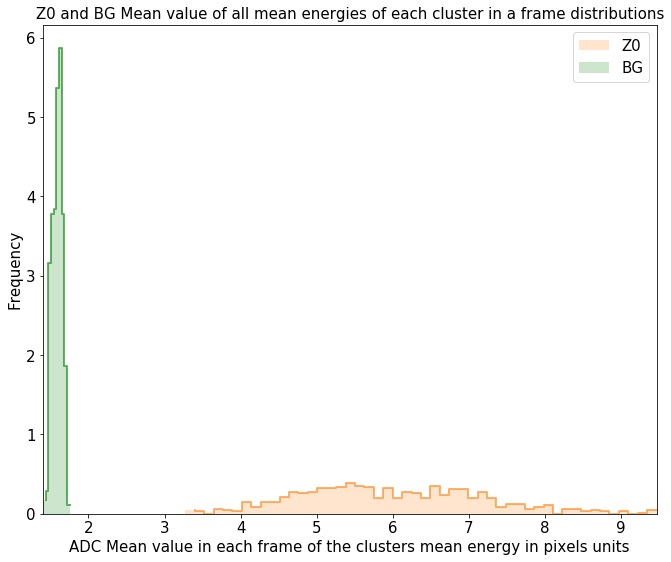

In [20]:
# Mean of cluster mean energies in each frame

plot_zeta_vs_parameter(zetas,'Mean of all mean energies in all clusters',data_dictionary['Mean_MeanEnergies'])
plot_set_of_histograms([data_dictionary['Mean_MeanEnergies'][0],data_dictionary['Mean_MeanEnergies'][-1]],[50,10],
    "Z0 and BG Mean value of all mean energies of each cluster in a frame distributions", 
    'Mean value in each frame of the clusters mean energy in pixels units',['Z0','BG'])

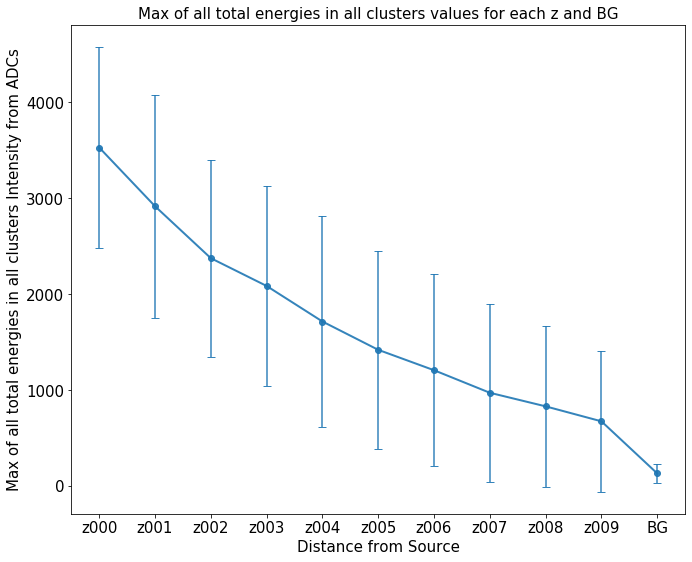

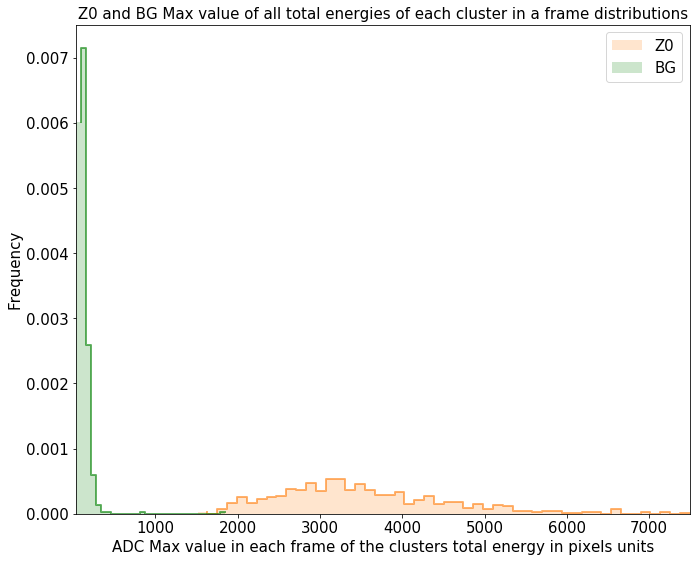

In [21]:
# Max of cluster total energies in each frame

plot_zeta_vs_parameter(zetas,'Max of all total energies in all clusters',data_dictionary['Max_TotalEnergies'])
plot_set_of_histograms([data_dictionary['Max_TotalEnergies'][0],data_dictionary['Max_TotalEnergies'][-1]],[50,30],
                   "Z0 and BG Max value of all total energies of each cluster in a frame distributions", 
                   'Max value in each frame of the clusters total energy in pixels units',['Z0','BG'])

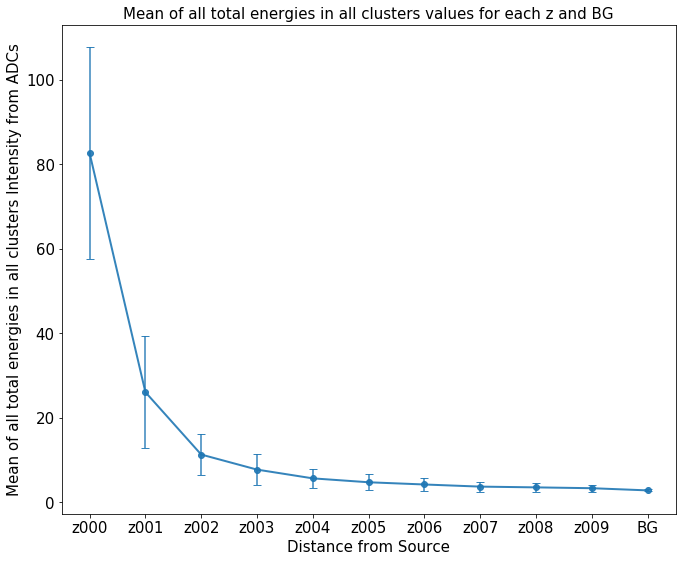

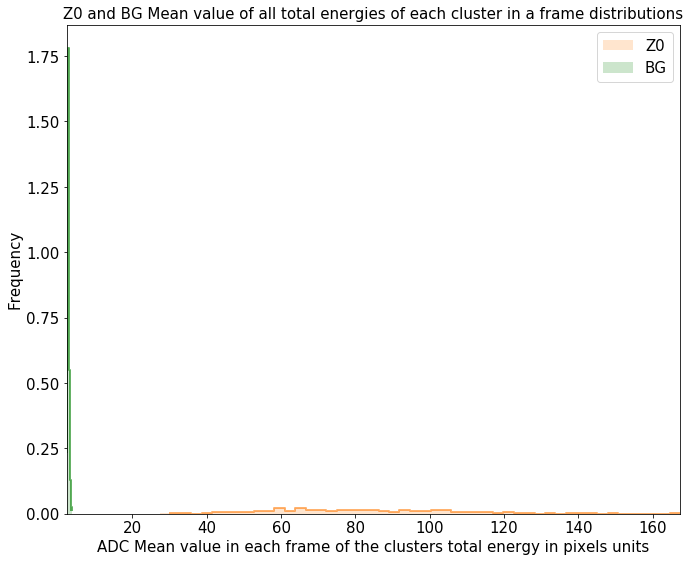

In [22]:
# Mean of cluster total energies in each frame

plot_zeta_vs_parameter(zetas,'Mean of all total energies in all clusters',data_dictionary['Mean_TotalEnergies'])
plot_set_of_histograms([data_dictionary['Mean_TotalEnergies'][0],data_dictionary['Mean_TotalEnergies'][-1]],[50,10],
                   "Z0 and BG Mean value of all total energies of each cluster in a frame distributions", 
                   'Mean value in each frame of the clusters total energy in pixels units',['Z0','BG'])

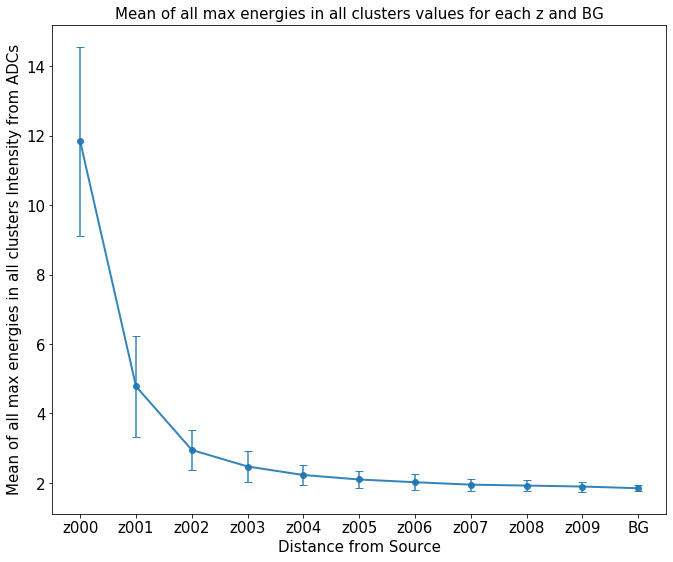

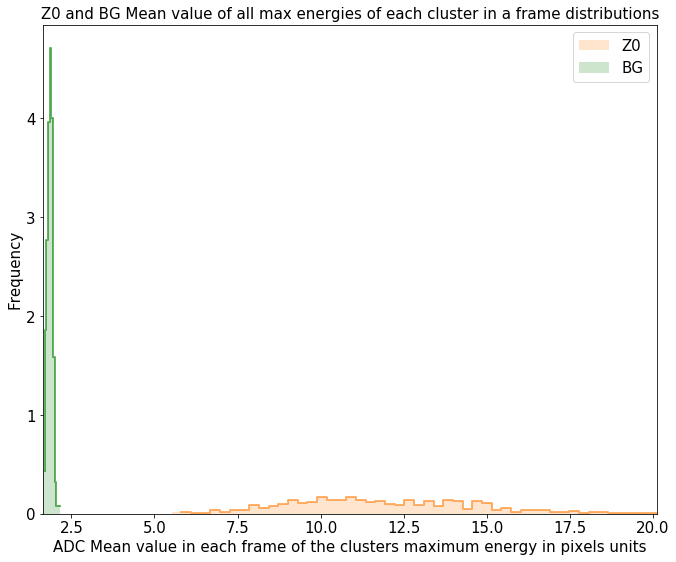

In [23]:
# Mean of cluster max energies in each frame

plot_zeta_vs_parameter(zetas,'Mean of all max energies in all clusters',data_dictionary['Mean_MaxEnergies'])
plot_set_of_histograms([data_dictionary['Mean_MaxEnergies'][0],data_dictionary['Mean_MaxEnergies'][-1]],[50,10],
                   "Z0 and BG Mean value of all max energies of each cluster in a frame distributions", 
                    'Mean value in each frame of the clusters maximum energy in pixels units',['Z0','BG'])

### Other Distributions

In [24]:
def plot_histogram(bin_edge,histograms,title):
    width=np.diff(bin_edge)[0]
    plt.figure(figsize=[11,9])
    plt.bar(bin_edge[:-1], histograms, color='w',edgecolor='k',width=width)
    plt.xlim(min(bin_edge), max(bin_edge))
    plt.xlabel('Value',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.title(title,fontsize=15)
    plt.show()

In [25]:
hist, bin_edges = np.histogram(data_dictionary['MeanFrame'].flatten(),bins = 120)
norm = sum(hist*np.diff(bin_edges))

In [26]:
# Fit to normal:
mu,var = scipy.stats.distributions.norm.fit(data_dictionary['MeanFrame'].flatten())
x_norm = np.linspace(min(bin_edges),max(bin_edges),120)
fit_normal = scipy.stats.distributions.norm.pdf(x_norm,mu,var)

In [27]:
'%.3f'%(mu)

'0.456'

In [28]:
def plot_fit_hist(x_norm,bin_edge,fit_normal,histograms,title):
    
    width=np.diff(bin_edge)[0]
    plt.figure(figsize=[11,9])
    
    # Plot Normal
    plt.plot(x_norm , fit_normal , c=(0.1,0.5,0.9) , linewidth = 2 , label = "Normal: mu:"+ '%.3f'%(mu) + ", var: "+ '%.3f'%(var))
    
    plt.bar(bin_edge[:-1], histograms, color='w',edgecolor='k',width=width)
    plt.xlim(min(bin_edge), max(bin_edge))
    plt.xlabel('Value',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend()
    plt.ylabel('Frequency',fontsize=15)
    plt.title(title,fontsize=15)
    plt.show()

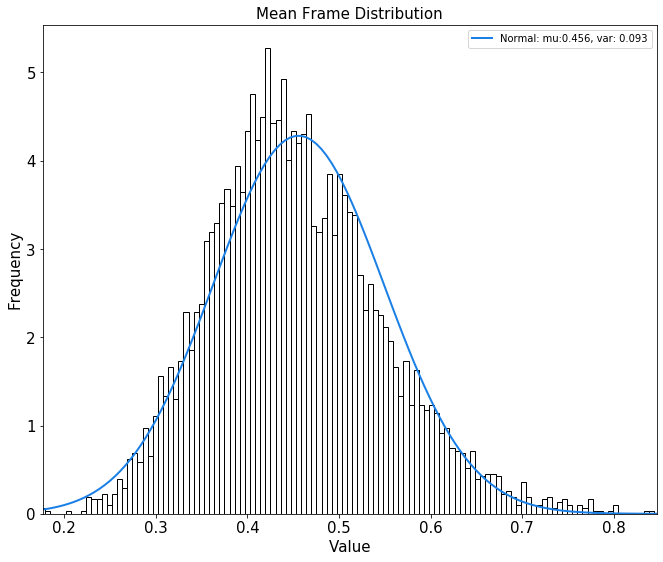

In [29]:
plot_fit_hist(x_norm, bin_edges, fit_normal ,hist/norm,'Mean Frame Distribution')

In [30]:
# Kolmogorov Smirnov Test:

ks_norm = scipy.stats.kstest(data_dictionary['MeanFrame'].flatten(), 'norm',)
print('Statistic: ', ks_norm[0], ', P-Value: ', ks_norm[1])

Statistic:  0.5967309901363359 , P-Value:  0.0


In [31]:
data_dictionary

{'ClustersAreaMax': array([[ 84,  58,  48, ...,  40,  45, 101],
        [ 58,  63,  34, ...,  82,  37,  61],
        [ 38,  46,  74, ...,  58,  29,  59],
        ...,
        [ 26,  25,  20, ...,  26,  51,  19],
        [ 21,  15,  64, ...,  18,  10,  29],
        [ 18,  38,  45, ...,  19,  23,  24]]),
 'ClustersAreaMean': array([[6.18083183, 3.35476956, 4.27118644, ..., 3.19709544, 4.85565217,
         5.09482759],
        [2.02557756, 2.20037279, 1.76694915, ..., 2.66877637, 1.61216271,
         2.35559265],
        [1.59985502, 1.727797  , 1.70877354, ..., 1.55654281, 1.66952381,
         1.96619718],
        ...,
        [1.48042506, 1.44733303, 1.54484536, ..., 1.62298851, 1.52706553,
         1.5245478 ],
        [1.5141844 , 1.36407767, 1.42396191, ..., 1.49821216, 1.48076923,
         1.53466351],
        [1.50881954, 1.53633721, 1.37373558, ..., 1.46210845, 1.44342964,
         1.36039495]]),
 'MaxFrame': array([[255, 224, 255, ..., 211, 255, 255],
        [255, 187, 190, ...,

In [32]:
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

In [33]:
filtered_data_dictionary1 = removekey(data_dictionary,'MeanFrame')
filtered_data_dictionary = removekey(filtered_data_dictionary1,'SigmaFrame')

## 3. Create a BDT classifier, KNN classifier and a Random Forest Classifier

### We create the dataframe of the 5500 frames and each frame's parameters

In [34]:
z_index = 10 # number of z distances  
NumDataPerClass = 500  # Number of data per class 

# We create the main classes array for creating dataframe
z_idx = ['z'+str(i) for i in range(z_index)]
z_idx.append('BG')

# Class labels with 5500 elements 500 for each class
class_labels = [zeta for zeta in z_idx for i in range(NumDataPerClass)]

# Store all classes in main dataframe
data_frame = pd.DataFrame({'Class':class_labels})
normalized_data_frame = pd.DataFrame({'Class':class_labels})

# Store the parameters in dataframe
for key in filtered_data_dictionary:
    data_frame[key] = np.array(data_dictionary[key]).flatten()
    normalized_data_frame[key] = np.array(data_dictionary[key]).flatten()/255

print(data_frame)

     Class  ClustersAreaMax  ClustersAreaMean  MaxFrame  Max_MeanEnergies  \
0       z0               84          6.180832       255         82.600000   
1       z0               58          3.354770       224         77.000000   
2       z0               48          4.271186       255        116.444444   
3       z0               66          4.906977       253         92.794872   
4       z0               65          5.699065       255         95.555556   
...    ...              ...               ...       ...               ...   
5495    BG               33          1.414767        30         18.250000   
5496    BG               16          1.346781        32         16.888889   
5497    BG               19          1.462108        27         13.000000   
5498    BG               23          1.443430        42         14.500000   
5499    BG               24          1.360395        43         23.250000   

      Max_TotalEnergies  Mean_MaxEnergies  Mean_MeanEnergies  \
0          

In [35]:
data_frame

,Class,ClustersAreaMax,ClustersAreaMean,MaxFrame,Max_MeanEnergies,Max_TotalEnergies,Mean_MaxEnergies,Mean_MeanEnergies,Mean_TotalEnergies,VarianceFrame
0,z0,84,6.180832,255,82.600000,4028.0,16.034358,7.537876,121.041591,1.173592
1,z0,58,3.354770,224,77.000000,3140.0,7.903537,4.200392,48.708467,1.094296
2,z0,48,4.271186,255,116.444444,3144.0,11.772128,6.019193,80.035782,1.250547
3,z0,66,4.906977,253,92.794872,3619.0,14.162791,6.960126,97.372093,1.348083
4,z0,65,5.699065,255,95.555556,2591.0,14.558879,7.094527,102.310280,1.109904
...,...,...,...,...,...,...,...,...,...,...
5495,BG,33,1.414767,30,18.250000,181.0,1.947159,1.705356,2.949692,0.848951
5496,BG,16,1.346781,32,16.888889,152.0,1.912876,1.692059,2.644206,0.807136
5497,BG,19,1.462108,27,13.000000,128.0,1.918828,1.656613,2.898282,1.007006
5498,BG,23,1.443430,42,14.500000,84.0,1.769804,1.537430,2.584157,0.486558


### Define the Random Forest Classifier

In [36]:
def RandomForestClassifierModel(DFrame,Classes_Name , MaxDepth , NumEstimators):
    ''' Function to create the model:
    Inputs:
    - DFrame: Data frame classes and parameters
    - Classes_Name: Name of the class
    - MaxDepth: Maximum depth in the tree cuts
    - NumEstimators: Number of estimators to include in model
    
    '''
    encoder = LabelEncoder() # Create a class label encoder
    DFrame[Classes_Name] = encoder.fit_transform(DFrame[Classes_Name])

    # Separate Parameters (input data) and Target(Classes or output data)
    parameters_data = DFrame.iloc[:,1:] # Parameters data
    target = DFrame[Classes_Name] # Classes data

    # Separate images in test and train sets:
    # We use 20% for testing 
    X_train, X_test, y_train, y_test = train_test_split(parameters_data, target, test_size = 0.20, random_state = 72)

    # Create the random forest classifier:
    r_forest_classifier = RandomForestClassifier(n_estimators = NumEstimators, max_depth = MaxDepth , random_state=84, n_jobs = -1)
    r_forest_classifier.fit(X_train, y_train)

    # Classification report
    # This takes class predictions hence we'll have to use .predict()
    y_hat_prime = r_forest_classifier.predict(X_test)
    print(f'Classification Report: \n{classification_report(y_test, y_hat_prime, zero_division=0)}')

    # Confusion Matrix 

    confusion_mat = confusion_matrix(y_test,y_hat_prime)
    cm_display = ConfusionMatrixDisplay(confusion_mat).plot()
#     plt.savefig(os.path.join(directory,f'CM_RandomForest_estimators_{NumEstimators}_depth_{MaxDepth}.png'))
    plt.show()


### Define the Boosted Decision Tree classifier

In [37]:
def AdaBoostClassifierModel(DFrame , Classes_Name , MaxDepth , NumEstimators):
    ''' Function to create the model:
    Inputs:
    - DFrame: Data frame classes and parameters
    - Classes_Name: Name of the class
    - MaxDepth: Maximum depth in the tree cuts
    - NumEstimators: Number of estimators to include in model
    
    '''
    encoder = LabelEncoder() # Create a class label encoder
    DFrame[Classes_Name] = encoder.fit_transform(DFrame[Classes_Name])
    
    # Separate Parameters (input data) and Target(Classes or output data)
    parameters_data = DFrame.iloc[:,1:] # Parameters data
    target = DFrame[Classes_Name] # Classes data

    # Separate images in test and train sets:
    # We use 20% for testing 
    X_train, X_test, y_train, y_test = train_test_split(parameters_data, target, test_size = 0.20, random_state = 72)

    # Create and fit an AdaBoost decision tree
    bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=MaxDepth), algorithm="SAMME", n_estimators=NumEstimators)
    bdt.fit(X_train, y_train)

    # Classification report
    # This takes class predictions hence we'll have to use .predict()
    y_hat_prime = bdt.predict(X_test)
    print(f'Classification Report: \n{classification_report(y_test, y_hat_prime, zero_division=0)}')

    # Confusion Matrix 
    
    plt.figure(figsize=(8,6))
    confusion_mat = confusion_matrix(y_test,y_hat_prime)
    cm_display = ConfusionMatrixDisplay(confusion_mat).plot()
#     plt.savefig(os.path.join(directory,f'CM_AdaBoost_estimators_{NumEstimators}_depth_{MaxDepth}.png'))
    plt.show()

### Define the K Nearest Neighbor classifier

In [38]:
def KNearestNeighborsModel(DFrame , Classes_Name, NumNeighbors):
    ''' Function to create the model:
    Inputs:
    - DFrame: Data frame classes and parameters
    - Classes_Name: Name of the class
    - NumNeighbors: Number of neighbors to include in model
    '''
    
    encoder = LabelEncoder() # Create a class label encoder
    DFrame[Classes_Name] = encoder.fit_transform(DFrame[Classes_Name])

    # Separate Parameters (input data) and Target(Classes or output data)
    parameters_data = DFrame.iloc[:,1:] # Parameters data
    target = DFrame[Classes_Name] # Classes data

    # Separate images in test and train sets:
    X_train, X_test, y_train, y_test = train_test_split(parameters_data, target, test_size = 0.20, random_state = 72)

    # Create and fit the K Nearest Neighbors model

    knn = KNeighborsClassifier(n_neighbors =  NumNeighbors)
    knn.fit(X_train, y_train)

    # Classification report
    # This takes class predictions hence we'll have to use .predict()
    y_hat_prime = knn.predict(X_test)
    print(f'Classification Report: \n{classification_report(y_test, y_hat_prime, zero_division=0)}')

    # Confusion Matrix 

    confusion_mat = confusion_matrix(y_test,y_hat_prime)
    cm_display = ConfusionMatrixDisplay(confusion_mat).plot()
#     plt.savefig(os.path.join(directory,f'CM_KNN_Neighbors_{NumNeighbors}.png'))
    plt.show()

In [39]:
data_frame

,Class,ClustersAreaMax,ClustersAreaMean,MaxFrame,Max_MeanEnergies,Max_TotalEnergies,Mean_MaxEnergies,Mean_MeanEnergies,Mean_TotalEnergies,VarianceFrame
0,z0,84,6.180832,255,82.600000,4028.0,16.034358,7.537876,121.041591,1.173592
1,z0,58,3.354770,224,77.000000,3140.0,7.903537,4.200392,48.708467,1.094296
2,z0,48,4.271186,255,116.444444,3144.0,11.772128,6.019193,80.035782,1.250547
3,z0,66,4.906977,253,92.794872,3619.0,14.162791,6.960126,97.372093,1.348083
4,z0,65,5.699065,255,95.555556,2591.0,14.558879,7.094527,102.310280,1.109904
...,...,...,...,...,...,...,...,...,...,...
5495,BG,33,1.414767,30,18.250000,181.0,1.947159,1.705356,2.949692,0.848951
5496,BG,16,1.346781,32,16.888889,152.0,1.912876,1.692059,2.644206,0.807136
5497,BG,19,1.462108,27,13.000000,128.0,1.918828,1.656613,2.898282,1.007006
5498,BG,23,1.443430,42,14.500000,84.0,1.769804,1.537430,2.584157,0.486558


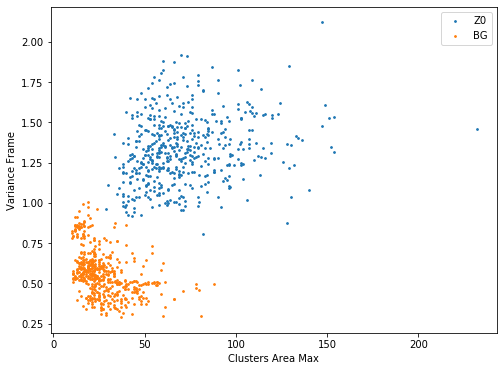

In [64]:

x1 = data_frame['ClustersAreaMax'][:500]
y1 = data_frame['VarianceFrame'][:500]

x2 = data_frame['ClustersAreaMax'][-500:]
y2 = data_frame['VarianceFrame'][-500:]

plt.figure(figsize=(8,6))
plt.scatter(x1,y1,s=3,c='tab:blue',label='Z0')
plt.scatter(x2,y2,s=3,c='tab:orange',label='BG')
plt.xlabel('Clusters Area Max')
plt.ylabel('Variance Frame')
plt.legend()
plt.show()

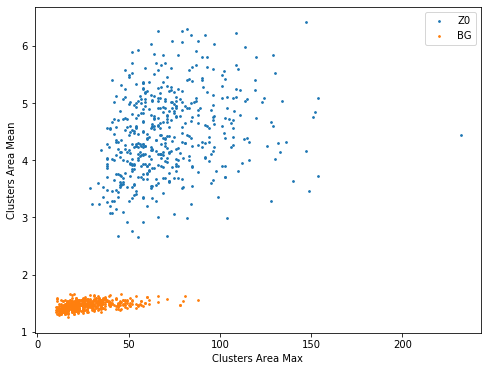

In [66]:
x1 = data_frame['ClustersAreaMax'][:500]
y1 = data_frame['ClustersAreaMean'][:500]

x2 = data_frame['ClustersAreaMax'][-500:]
y2 = data_frame['ClustersAreaMean'][-500:]

plt.figure(figsize=(8,6))
plt.scatter(x1,y1,s=3,c='tab:blue',label='Z0')
plt.scatter(x2,y2,s=3,c='tab:orange',label='BG')
plt.xlabel('Clusters Area Max')
plt.ylabel('Clusters Area Mean')
plt.legend()
plt.show()

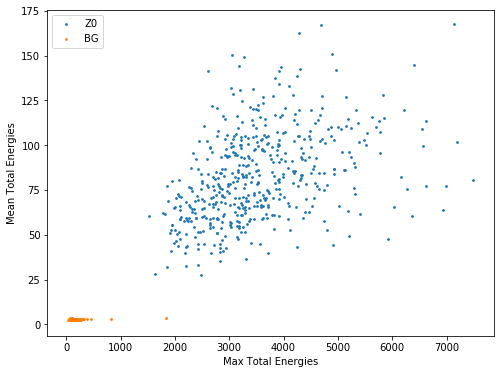

In [69]:
x1 = data_frame['Max_TotalEnergies'][:500]
y1 = data_frame['Mean_TotalEnergies'][:500]

x2 = data_frame['Max_TotalEnergies'][-500:]
y2 = data_frame['Mean_TotalEnergies'][-500:]

plt.figure(figsize=(8,6))
plt.scatter(x1,y1,s=3,c='tab:blue',label='Z0')
plt.scatter(x2,y2,s=3,c='tab:orange',label='BG')
plt.xlabel('Max Total Energies')
plt.ylabel('Mean Total Energies')
plt.legend()
plt.show()

### Results for AdaBoost:

Classification Report: 
              precision    recall  f1-score   support

           0       0.60      0.93      0.73        86
           1       0.96      0.97      0.97       103
           2       0.86      0.80      0.83       105
           3       0.52      0.66      0.59       113
           4       0.38      0.30      0.33       105
           5       0.23      0.30      0.26        93
           6       0.28      0.25      0.27       107
           7       0.21      0.20      0.20        86
           8       0.24      0.19      0.21       102
           9       0.19      0.15      0.17       102
          10       0.24      0.21      0.23        98

    accuracy                           0.45      1100
   macro avg       0.43      0.45      0.43      1100
weighted avg       0.43      0.45      0.44      1100



<Figure size 576x432 with 0 Axes>

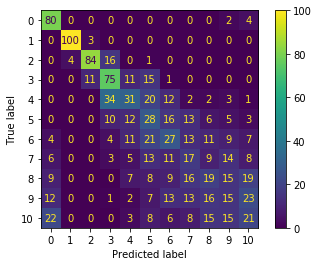

In [40]:
# Using max depth = 18 and 150 estimators:
AdaBoostClassifierModel(data_frame,'Class',18,250)

Classification Report: 
              precision    recall  f1-score   support

           0       0.63      0.88      0.73        86
           1       0.96      0.97      0.97       103
           2       0.86      0.81      0.83       105
           3       0.57      0.65      0.60       113
           4       0.36      0.31      0.34       105
           5       0.25      0.33      0.28        93
           6       0.30      0.25      0.27       107
           7       0.18      0.19      0.18        86
           8       0.24      0.20      0.22       102
           9       0.27      0.18      0.21       102
          10       0.27      0.29      0.28        98

    accuracy                           0.46      1100
   macro avg       0.44      0.46      0.45      1100
weighted avg       0.45      0.46      0.45      1100



<Figure size 576x432 with 0 Axes>

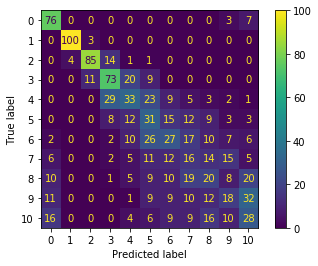

In [134]:
# Using max depth = 11 and 250 estimators:
AdaBoostClassifierModel(data_frame,'Class',11,250)

### Results for KNN:

Classification Report: 
              precision    recall  f1-score   support

           0       0.53      0.94      0.68        86
           1       0.74      0.84      0.79       103
           2       0.33      0.49      0.39       105
           3       0.24      0.31      0.27       113
           4       0.15      0.15      0.15       105
           5       0.12      0.12      0.12        93
           6       0.27      0.17      0.21       107
           7       0.11      0.09      0.10        86
           8       0.15      0.10      0.12       102
           9       0.31      0.19      0.23       102
          10       0.19      0.12      0.15        98

    accuracy                           0.32      1100
   macro avg       0.29      0.32      0.29      1100
weighted avg       0.29      0.32      0.29      1100



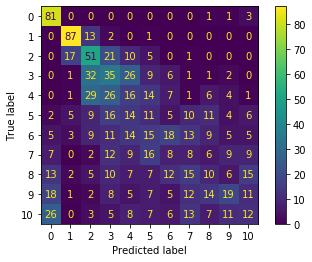

In [41]:
# Using 12 neighbors:
KNearestNeighborsModel(data_frame, 'Class' , 18)

### Results for Random Forest:

Classification Report: 
              precision    recall  f1-score   support

           0       0.57      0.94      0.71        86
           1       0.96      0.97      0.97       103
           2       0.88      0.84      0.86       105
           3       0.60      0.72      0.66       113
           4       0.42      0.31      0.36       105
           5       0.26      0.42      0.32        93
           6       0.26      0.20      0.22       107
           7       0.17      0.14      0.15        86
           8       0.23      0.22      0.22       102
           9       0.20      0.15      0.17       102
          10       0.29      0.19      0.23        98

    accuracy                           0.46      1100
   macro avg       0.44      0.46      0.44      1100
weighted avg       0.45      0.46      0.45      1100



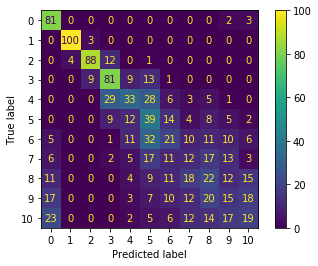

In [42]:
# Max depth = 12, Estimators = 250
RandomForestClassifierModel(data_frame ,'Class',12,250)

Classification Report: 
              precision    recall  f1-score   support

           0       0.59      0.95      0.73        86
           1       0.97      0.97      0.97       103
           2       0.85      0.84      0.85       105
           3       0.58      0.67      0.62       113
           4       0.41      0.32      0.36       105
           5       0.26      0.39      0.31        93
           6       0.30      0.23      0.26       107
           7       0.17      0.17      0.17        86
           8       0.24      0.21      0.22       102
           9       0.26      0.19      0.22       102
          10       0.31      0.22      0.26        98

    accuracy                           0.47      1100
   macro avg       0.45      0.47      0.45      1100
weighted avg       0.46      0.47      0.46      1100



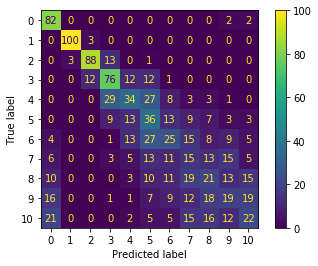

In [43]:
# Max depth = 15, Estimators = 350
RandomForestClassifierModel(data_frame ,'Class',15,350)

## 4. Create a binary BDT classifier, KNN classifier and a Random Forest Classifier 

In [44]:
def RandomForestClassifierModelBinary(DFrame,Classes_Name , MaxDepth , NumEstimators):
    ''' Function to create the model:
    Inputs:
    - DFrame: Data frame classes and parameters
    - Classes_Name: Name of the class
    - MaxDepth: Maximum depth in the tree cuts
    - NumEstimators: Number of estimators to include in model'''
    encoder = LabelEncoder()
    DFrame[Classes_Name] = encoder.fit_transform(DFrame[Classes_Name])

    # Separate Parameters (input data) and Target(Classes or output data)
    parameters_data = DFrame.iloc[:,1:]
    target = DFrame[Classes_Name]

    # Separate images in test and train sets:
    X_train, X_test, y_train, y_test = train_test_split(parameters_data, target, test_size = 0.20, random_state = 72)

    # Create the random forest classifier:
    r_forest_classifier = RandomForestClassifier(n_estimators = NumEstimators, max_depth = MaxDepth , random_state=84, n_jobs = -1)
    r_forest_classifier.fit(X_train, y_train)

    # Classification report
    # This takes class predictions hence we'll have to use .predict()
    y_hat_prime = r_forest_classifier.predict(X_test)
#     print(f'Classification Report: \n{classification_report(y_test, y_hat_prime, zero_division=0)}')

    # Confusion Matrix 

    confusion_mat = confusion_matrix(y_test,y_hat_prime)
#     cm_display = ConfusionMatrixDisplay(confusion_mat).plot()
    # plt.savefig(os.path.join(directory,f'CM_RandomForest_estimators_{NumEstimators}_depth_{MaxDepth}.png'))
#     plt.show()

    # Data for Roc Curve:

    y_pred = r_forest_classifier.predict_proba(X_test) # log loss requires predictions as probabilities
    
    # Returns y test and y predicted
    return y_test,y_pred

In [50]:
def AdaBoostClassifierModelBinary(DFrame , Classes_Name , MaxDepth , NumEstimators):

    encoder = LabelEncoder()
    DFrame[Classes_Name] = encoder.fit_transform(DFrame[Classes_Name])

    # Separate Parameters (input data) and Target(Classes or output data)
    parameters_data = DFrame.iloc[:,1:]
    target = DFrame[Classes_Name]

    # Separate images in test and train sets:
    X_train, X_test, y_train, y_test = train_test_split(parameters_data, target, test_size = 0.20, random_state = 72)

    #	Create	and	fit an AdaBoost decision tree
    bdt	= AdaBoostClassifier(DecisionTreeClassifier(max_depth=MaxDepth), algorithm="SAMME", n_estimators=NumEstimators)
    bdt.fit(X_train, y_train)

    # Classification report
    # This takes class predictions hence we'll have to use .predict()
    y_hat_prime = bdt.predict(X_test)
    print(f'Classification Report: \n{classification_report(y_test, y_hat_prime, zero_division=0)}')

    # Confusion Matrix 

    confusion_mat = confusion_matrix(y_test,y_hat_prime)
    # cm_display = ConfusionMatrixDisplay(confusion_mat).plot()
    # plt.savefig(os.path.join(directory,f'CM_AdaBoost_estimators_{NumEstimators}_depth_{MaxDepth}.png'))

    # Data for Roc Curve:
    y_pred = bdt.predict_proba(X_test) # log loss requires predictions as probabilities

    return y_test,y_pred

In [46]:
def KNearestNeighborsModelBinary(DFrame , Classes_Name, NumNeighbors):

    encoder = LabelEncoder()
    DFrame[Classes_Name] = encoder.fit_transform(DFrame[Classes_Name])

    # Separate Parameters (input data) and Target(Classes or output data)
    parameters_data = DFrame.iloc[:,1:]
    target = DFrame[Classes_Name]

    # Separate images in test and train sets:
    X_train, X_test, y_train, y_test = train_test_split(parameters_data, target, test_size = 0.20, random_state = 72)

    # Create and fit the K Nearest Neighbors model

    knn = KNeighborsClassifier(n_neighbors =  NumNeighbors)
    knn.fit(X_train, y_train)

    # Classification report
    # This takes class predictions hence we'll have to use .predict()
    y_hat_prime = knn.predict(X_test)
#     print(f'Classification Report: \n{classification_report(y_test, y_hat_prime, zero_division=0)}')

    # Confusion Matrix 

    confusion_mat = confusion_matrix(y_test,y_hat_prime)
    # cm_display = ConfusionMatrixDisplay(confusion_mat).plot()
    # plt.savefig(os.path.join(directory,f'CM_KNN_Neighbors_{NumNeighbors}.png'))

    # Data for Roc Curve:
    y_pred = knn.predict_proba(X_test) # log loss requires predictions as probabilities

    return y_test,y_pred

### Create Binary Data Frames

In [47]:
List_dataframes = [] # Here we will store the data frames of each z vs BG

# We create the main classes array for creating dataframe
z_idx_binary = ['z'+str(i) for i in range(z_index)]

for z in z_idx_binary:
    # We create the main classes array for creating dataframe
    classes = [z,'BG']
    
    # Class labels with 5500 elements 500 for each class
    class_labels = [cl for cl in classes for i in range(NumDataPerClass)]

    # Store all classes in main dataframe
    data_frame_binary = pd.DataFrame({'Class':class_labels})
    
    List_dataframes.append(data_frame_binary)

In [48]:
# Iterate over the list of dataframes, each dataframe is a 1000 row data between z0 and BG , z1 and BG, ... ,z9 and BG
for idx, dataF in enumerate(List_dataframes):
    # Iterate over the parameters and store them in each dataframe 
    for key in filtered_data_dictionary:
        dataF[key] = list(filtered_data_dictionary[key][idx]) + list(filtered_data_dictionary[key][10])

In [49]:
List_dataframes

[    Class  ClustersAreaMax  ClustersAreaMean  MaxFrame  Max_MeanEnergies  \
 0      z0               84          6.180832       255         82.600000   
 1      z0               58          3.354770       224         77.000000   
 2      z0               48          4.271186       255        116.444444   
 3      z0               66          4.906977       253         92.794872   
 4      z0               65          5.699065       255         95.555556   
 ..    ...              ...               ...       ...               ...   
 995    BG               33          1.414767        30         18.250000   
 996    BG               16          1.346781        32         16.888889   
 997    BG               19          1.462108        27         13.000000   
 998    BG               23          1.443430        42         14.500000   
 999    BG               24          1.360395        43         23.250000   
 
      Max_TotalEnergies  Mean_MaxEnergies  Mean_MeanEnergies  \
 0        

### We train each data frame and determine their respective ROC curves

#### a) Using BDT

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00        91

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00        91

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00        91

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
we

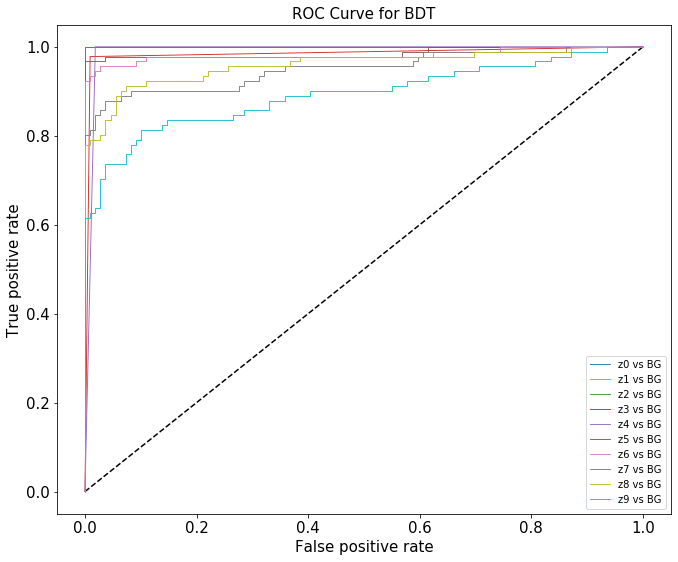

In [51]:
plt.figure(figsize=(11,9))
plt.plot([0, 1], [0, 1], 'k--')
for idx,dataF in enumerate(List_dataframes):
    ytest_BDT, ypred_BDT =  AdaBoostClassifierModelBinary(dataF, 'Class', 8 , 300)
    fpr_BDT , tpr_BDT , _ = roc_curve(ytest_BDT, ypred_BDT[:,1])
    plt.plot(fpr_BDT, tpr_BDT, label=z_idx_binary[idx]+' vs BG',linewidth = 0.9)
plt.xlabel('False positive rate',fontsize=15)
plt.ylabel('True positive rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve for BDT',fontsize=15)
plt.legend(loc='best')
plt.show()

#### Using Random Forest Classifier 

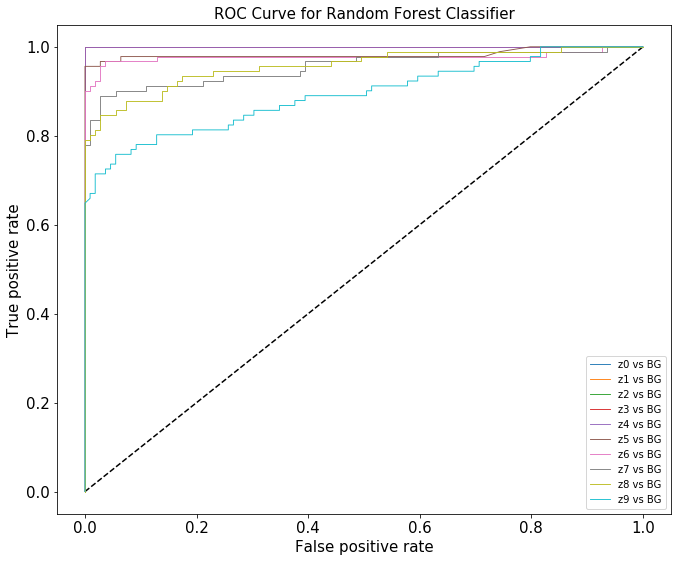

In [160]:
plt.figure(figsize=(11,9))
plt.plot([0, 1], [0, 1], 'k--')
for idx,dataF in enumerate(List_dataframes):
    ytest_RFC, ypred_RFC =  RandomForestClassifierModelBinary(dataF, 'Class', 15 , 350)
    fpr_RFC , tpr_RFC , _ = roc_curve(ytest_RFC, ypred_RFC[:,1])
    plt.plot(fpr_RFC, tpr_RFC, label=z_idx_binary[idx]+' vs BG',linewidth = 0.9)
plt.xlabel('False positive rate',fontsize=15)
plt.ylabel('True positive rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve for Random Forest Classifier',fontsize=15)
plt.legend(loc='best')
plt.show()

####  Using K Nearest Neighbors

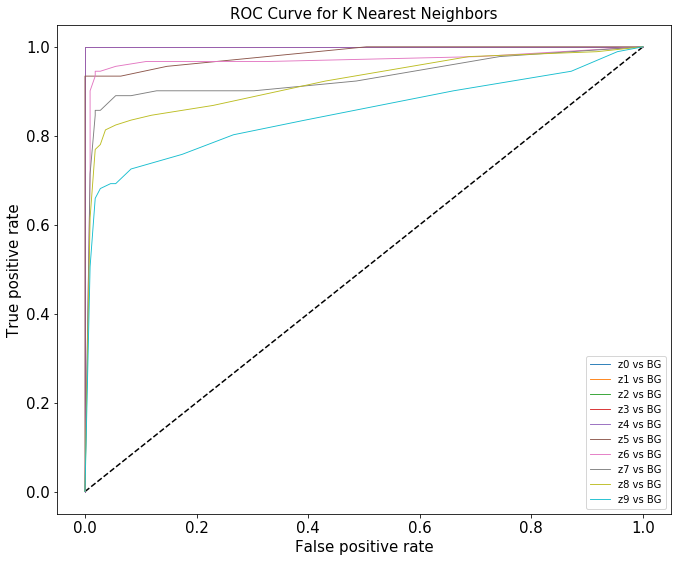

In [161]:
plt.figure(figsize=(11,9))
plt.plot([0, 1], [0, 1], 'k--')
for idx,dataF in enumerate(List_dataframes):
    ytest_KNN, ypred_KNN =  KNearestNeighborsModelBinary(dataF, 'Class', 12)
    fpr_KNN , tpr_KNN , _ = roc_curve(ytest_KNN, ypred_KNN[:,1])
    plt.plot(fpr_KNN, tpr_KNN, label=z_idx_binary[idx]+' vs BG',linewidth = 0.9)
plt.xlabel('False positive rate',fontsize=15)
plt.ylabel('True positive rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve for K Nearest Neighbors',fontsize=15)
plt.legend(loc='best')
plt.show()

### Calculating errors of each model

In [185]:
def AdaBoostClassifierModelError(DFrame , Classes_Name , MaxDepth , NumEstimators):
    ''' Function to create the model:
    Inputs:
    - DFrame: Data frame classes and parameters
    - Classes_Name: Name of the class
    - MaxDepth: Maximum depth in the tree cuts
    - NumEstimators: Number of estimators to include in model
    
    '''
    encoder = LabelEncoder() # Create a class label encoder
    DFrame[Classes_Name] = encoder.fit_transform(DFrame[Classes_Name])
    
    # Separate Parameters (input data) and Target(Classes or output data)
    parameters_data = DFrame.iloc[:,1:] # Parameters data
    target = DFrame[Classes_Name] # Classes data

    # Separate images in test and train sets:
    # We use 20% for testing 
    X_train, X_test, y_train, y_test = train_test_split(parameters_data, target, test_size = 0.20, random_state = 72)

    # Create and fit an AdaBoost decision tree
    bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=MaxDepth), algorithm="SAMME", n_estimators=NumEstimators)
    bdt.fit(X_train, y_train)

    # Classification report
    # This takes class predictions hence we'll have to use .predict()
    y_hat_prime = bdt.predict(X_test)
#     print(f'Classification Report: \n{classification_report(y_test, y_hat_prime, zero_division=0)}')
    
    

    # Confusion Matrix 
    
#     plt.figure(figsize=(8,6))
#     confusion_mat = confusion_matrix(y_test,y_hat_prime)
#     cm_display = ConfusionMatrixDisplay(confusion_mat).plot()
#     plt.savefig(os.path.join(directory,f'CM_AdaBoost_estimators_{NumEstimators}_depth_{MaxDepth}.png'))
#     plt.show()
    return y_hat_prime , y_test

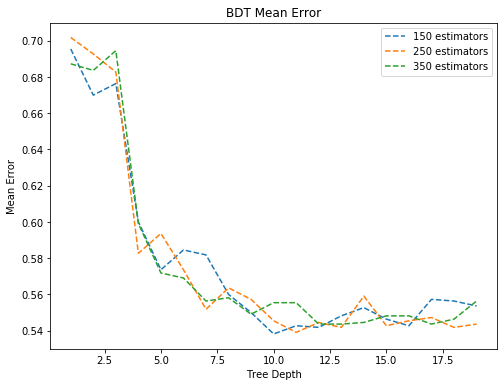

In [197]:
all_errors = []
estimators = list(range(150,400,100))
for estim in range(150,400,100):
    
    error_BDT = []

    for i in range(1,20):
        y_pred,y_real = AdaBoostClassifierModelError(data_frame , 'Class' , i , estim)
        error_BDT.append(np.mean(y_pred != y_real))
    
    all_errors.append(error_BDT)
    

plt.figure(figsize=(8,6))
for idx,errors in enumerate(all_errors):
    plt.plot(range(1,20),errors, linestyle='dashed',label=f'{estimators[idx]} estimators')
    
plt.title('BDT Mean Error')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Error')
plt.legend()


In [212]:
def KNearestNeighborsModelError(DFrame , Classes_Name, NumNeighbors):
    ''' Function to create the model:
    Inputs:
    - DFrame: Data frame classes and parameters
    - Classes_Name: Name of the class
    - NumNeighbors: Number of neighbors to include in model'''
    
    encoder = LabelEncoder() # Create a class label encoder
    DFrame[Classes_Name] = encoder.fit_transform(DFrame[Classes_Name])

    # Separate Parameters (input data) and Target(Classes or output data)
    parameters_data = DFrame.iloc[:,1:] # Parameters data
    target = DFrame[Classes_Name] # Classes data

    # Separate images in test and train sets:
    X_train, X_test, y_train, y_test = train_test_split(parameters_data, target, test_size = 0.20, random_state = 72)

    # Create and fit the K Nearest Neighbors model

    knn = KNeighborsClassifier(n_neighbors =  NumNeighbors)
    knn.fit(X_train, y_train)

    # Classification report
    # This takes class predictions hence we'll have to use .predict()
    y_hat_prime = knn.predict(X_test)
#     print(f'Classification Report: \n{classification_report(y_test, y_hat_prime, zero_division=0)}')

    # Confusion Matrix 

#     confusion_mat = confusion_matrix(y_test,y_hat_prime)
#     cm_display = ConfusionMatrixDisplay(confusion_mat).plot()
# #     plt.savefig(os.path.join(directory,f'CM_KNN_Neighbors_{NumNeighbors}.png'))
#     plt.show()
    return y_hat_prime , y_test

Minimum Error:  0.6836363636363636
K Value:  18


Text(0, 0.5, 'Mean Error')

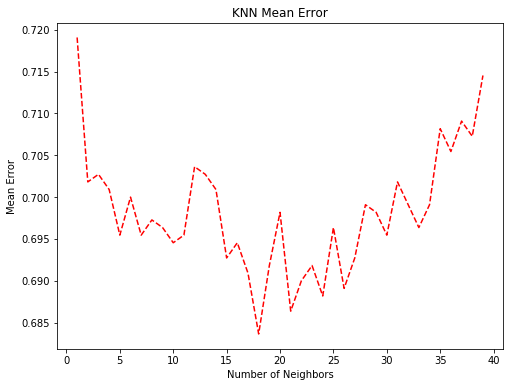

In [216]:
error_BDT = []
for i in range(1,40):
    y_pred,y_real = KNearestNeighborsModelError(data_frame , 'Class' , i )
    error_BDT.append(np.mean(y_pred != y_real))
print('Minimum Error: ',min(error_BDT))
print('K Value: ', list(range(1,40))[error_BDT.index(min(error_BDT))])
plt.figure(figsize=(8,6))
plt.plot(range(1,40),error_BDT, color='red', linestyle='dashed')
plt.title('KNN Mean Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Error')

In [72]:
data_frame['Class'].value_counts()

7     500
3     500
10    500
6     500
2     500
9     500
5     500
1     500
8     500
4     500
0     500
Name: Class, dtype: int64

In [3]:
a = np.array([np.array([1,2,3]),np.array([45,5,5]),np.array([3,33,3,3])])
b = a.tolist()

In [5]:
b1 = [elem.tolist() for elem in b]

In [8]:
type(b1[0])

list